# Improving Job Discovery Through Recommendation


## Problem Statement
<a id="introduction"></a>

Traditional job search engines depend heavily on **keywords** such as job title and location. 
This approach fails to capture the fact that job titles often vary significantly across companies, 
even when the roles require similar skills. For example, jobs related to therapy may be listed as 
*Behavior Technician*, *SPED Teacher*, *School Behavior Technician*, or *Occupational Therapist – School Setting*. 
A candidate searching only for “Therapist” risks missing these relevant opportunities.

This mismatch creates a **semantic gap** between how jobs are labeled and how candidates search, 
leading to missed opportunities for candidates and reduced visibility for employers.

## Business Understanding
The goal of this project is to improve the **job discovery process** by recommending similar job postings 
once a user selects or views a specific job. Instead of requiring candidates to know every possible title variation, 
the system will highlight relevant opportunities by analyzing shared **skills, job descriptions, and responsibilities**, 
as well as factoring in **location context**.

**Business Benefits:**
- **For candidates:** Expands awareness of opportunities that align with their profile and interests.  
- **For employers:** Increases exposure of their postings to qualified candidates.  
- **For the platform:** Improves engagement, retention, and overall value proposition.
  
## Machine Learning Solution
The solution will be developed as a **content-based recommendation system** using the 
[LinkedIn Job Postings dataset](https://huggingface.co/datasets/datastax/linkedin_job_listings).

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install -q datasets


[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:

# Downloading the dataset locally and store as csv file

from datasets import load_dataset
import os

num_rows = 10000
dataset_stream = load_dataset("datastax/linkedin_job_listings", split="train", streaming=True)
limited_dataset_stream = dataset_stream.take(num_rows)

df = pd.DataFrame(limited_dataset_stream)

display(df.sample(1))

output_file="data/job_postings.csv"

# Ensure data directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Delete old file if it exists
if os.path.exists(output_file):
    os.remove(output_file)
    print(f"Deleted existing file: {output_file}")

df.to_csv(output_file, index=False)


'\n# Downloading the dataset locally and store as csv file\n\nfrom datasets import load_dataset\nimport os\n\nnum_rows = 10000\ndataset_stream = load_dataset("datastax/linkedin_job_listings", split="train", streaming=True)\nlimited_dataset_stream = dataset_stream.take(num_rows)\n\ndf = pd.DataFrame(limited_dataset_stream)\n\ndisplay(df.sample(1))\n\noutput_file="data/job_postings.csv"\n\n# Ensure data directory exists\nos.makedirs(os.path.dirname(output_file), exist_ok=True)\n\n# Delete old file if it exists\nif os.path.exists(output_file):\n    os.remove(output_file)\n    print(f"Deleted existing file: {output_file}")\n\ndf.to_csv(output_file, index=False)\n'

In [4]:
df = pd.read_csv('data/job_postings.csv')

df2 = df.copy(deep=True)

## Exploratory Analysis
- Basic Data cleaning
- Plotting various charts to understand the dataset bettter


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   job_id                      10000 non-null  int64  
 1   company_name                9714 non-null   object 
 2   title                       10000 non-null  object 
 3   description                 10000 non-null  object 
 4   max_salary                  2366 non-null   float64
 5   pay_period                  2921 non-null   object 
 6   location                    10000 non-null  object 
 7   company_id                  9715 non-null   float64
 8   views                       9946 non-null   float64
 9   med_salary                  555 non-null    float64
 10  min_salary                  2366 non-null   float64
 11  formatted_work_type         10000 non-null  object 
 12  applies                     2151 non-null   float64
 13  original_listed_time        1000

### Field Summary 

##### Identity & Core Text
- **job_id** : Unique posting ID. This can be used to identify specifc job(primary key)
- **company_name** :  Employer name.  
- **title** : Job title.  
- **description** : Full job description text.
- **skills_desc** : Skills extracted/parsed from the post (free text list).  
##### Job Type & Seniority
- **work_type** : Canonical job type (e.g., FULL_TIME).  
- **formatted_work_type** : Human-readable variant of job type.  
- **formatted_experience_level** : Seniority bucket (e.g., Entry level, Mid-Senior).  
- **remote_allowed** : Remote eligibility flag (0/1).  
- **posting_domain** : Domain the job was posted from.  
##### Location & Geo
- **location** : Free-form location string (city, state, country) 
- **zip_code** : U.S. ZIP (numeric). Missing for non-US rows.  
- **fips** : U.S. county FIPS code if resolvable.
##### Compensation
- **min_salary**, **med_salary**, **max_salary** : Salary range; currency given by `currency`. Often sparse; treat outliers carefully.  
- **currency** : Currency code (e.g., USD).  
- **pay_period** : Compensation cadence (e.g., HOURLY, YEARLY).  
- **compensation_type** : Compensation category (e.g., BASE_SALARY).  
- **normalized_salary** : Dataset-provided normalized pay (likely annualized).  
##### Posting & Lifecycle Timestamps
- **listed_time** : When the post first appeared.  
- **original_listed_time** : Original creation time on source.  
- **expiry** : Expiration time if provided.  
- **closed_time** : Closure time if the role closed.
##### Application & Engagement
- **application_type** : How to apply (e.g., LinkedIn Easy Apply).  
- **application_url** : External application link (may be null).  
- **job_posting_url** : Source posting URL.  
- **applies** : Count of applications (if available).  
- **views** : View count (if available).  
- **sponsored** : Whether the post is sponsored (0/1). 


In [6]:
df.sample(2)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
1763,3884439188,North American Dental Group (NADG),Assistant Office Manager,“Open Up” To A Whole New Dental Experience\n\n...,NaN,NaN,"Pickerington, OH",2831596.0,2.0,NaN,...,NaN,1.712349e+12,careers2-nadentalgroup.icims.com,0,PART_TIME,NaN,NaN,NaN,43147.0,39045.0
5813,3885104456,LHH,"Tax Accountant, Dallas (75K-85K)",We are looking to fill a Tax Accountant role w...,NaN,NaN,"Dallas, TX",5235.0,4.0,NaN,...,NaN,1.712401e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,75201.0,48113.0


### Data cleaning
- Since the business goal is to build a recommendation system, job similarities will be derived primarily from the following fields: **Job Description**, **Skills**, **Title**, and **Location**.
- The **job_id** serves as the primary key to uniquely identify each posting, while other columns are not essential for the MVP. 

In [7]:
print("\nMissing values:\n", df.isnull().sum().sort_values(ascending=False).head(15))


Missing values:
 closed_time                   9956
skills_desc                   9947
med_salary                    9445
remote_allowed                8675
applies                       7849
max_salary                    7634
min_salary                    7634
currency                      7079
compensation_type             7079
pay_period                    7079
normalized_salary             7079
formatted_experience_level    3309
posting_domain                3279
application_url               3071
fips                          2190
dtype: int64


In [8]:
# select only the features required for recommendation
selected_columns = ["job_id", "description", "skills_desc", "company_name", "title", "location", "listed_time" ]
df2 = df2[selected_columns]

# rename the description for better readability
df2 = df2.rename(columns={"description": "job_desc"})

In [9]:
# Convert listed_date to datetime 
df2["listed_time"] = pd.to_datetime(df2["listed_time"], unit="ms")

# Following feature considered as basic for a job requirement, remove if any of the data is missing
# company_name is available 97.14%, drop the missing one
df2 = df2.dropna(subset=["title", "company_name", "job_desc", "location"])

df2 = df2.drop_duplicates(subset=['job_id'])

#impute data
df2['job_desc'] = df2['job_desc'].fillna('')
df2['skills_desc'] = df2['skills_desc'].fillna('')
df2['title'] = df2['title'].fillna('')

### Data plots


/var/folders/7f/51h6zr6x17x50vbq88rj1xs40000gn/T/ipykernel_62233/1571517154.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="mako")


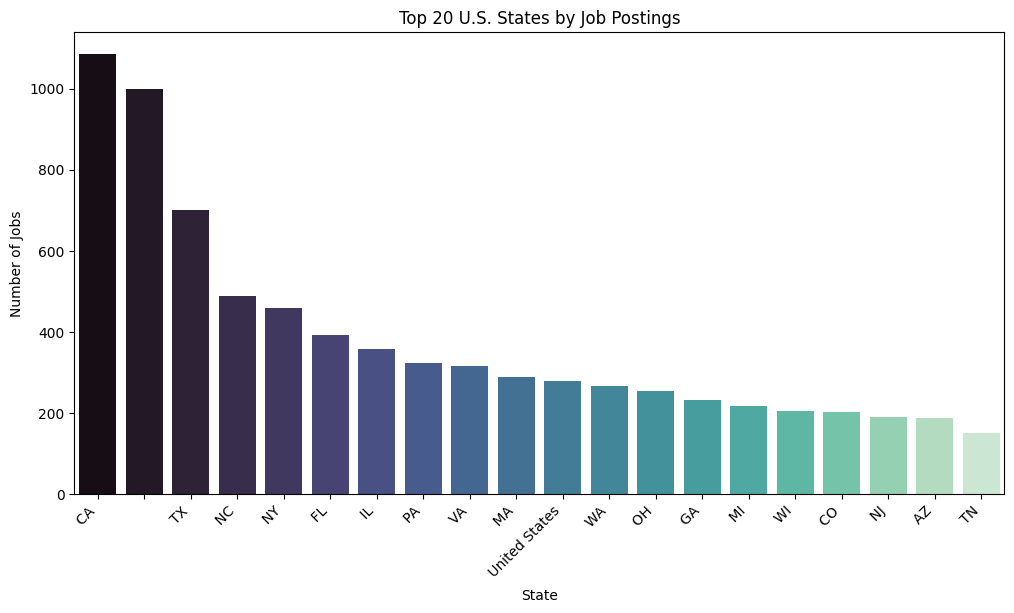

In [10]:
df2[["city", "state"]] = df2["location"].str.split(",", n=2, expand=True)[[0, 1]]
df2['city'] = df2['city'].fillna('')
df2['state'] = df2['state'].fillna('')

# Count jobs per state
state_counts = df2["state"].value_counts().head(20)  # top 20 states

plt.figure(figsize=(12,6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette="mako")
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 U.S. States by Job Postings")
plt.xlabel("State")
plt.ylabel("Number of Jobs")
plt.show()

# 10% of data doesn't have state info, need to do impuite. refer feature engineering section,

/var/folders/7f/51h6zr6x17x50vbq88rj1xs40000gn/T/ipykernel_62233/2103876442.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_titles.index, x=top_titles.values, palette="mako")


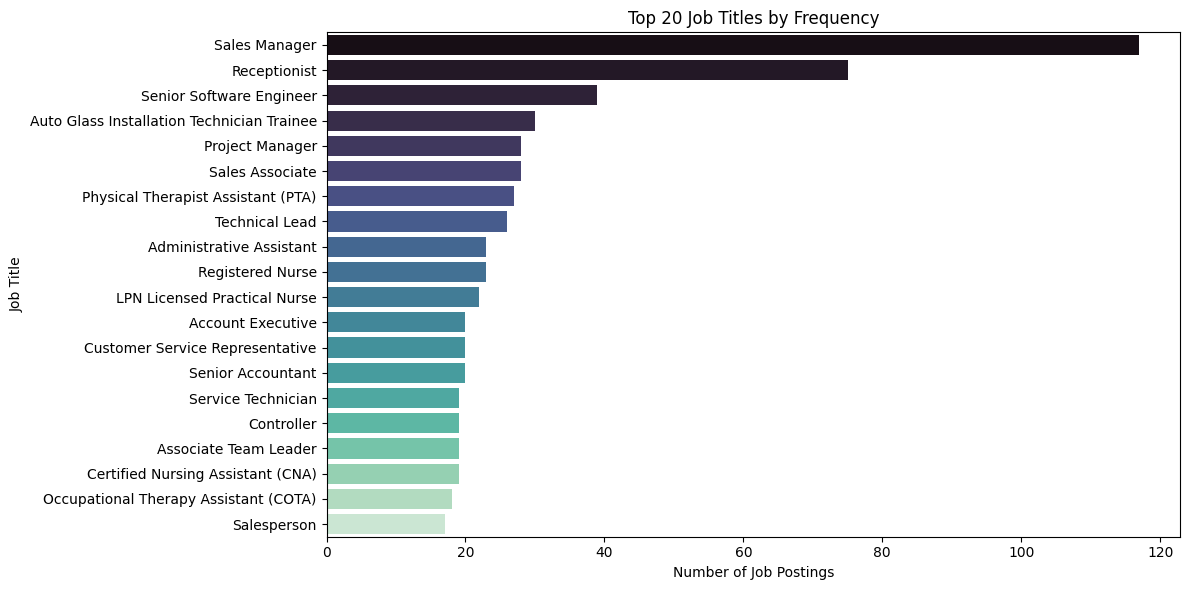

In [11]:
top_titles = df["title"].value_counts().head(20)

plt.figure(figsize=(12,6))
sns.barplot(y=top_titles.index, x=top_titles.values, palette="mako")
plt.title("Top 20 Job Titles by Frequency")
plt.xlabel("Number of Job Postings")
plt.ylabel("Job Title")
plt.tight_layout()
plt.show()

/var/folders/7f/51h6zr6x17x50vbq88rj1xs40000gn/T/ipykernel_62233/867101905.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df2["desc_len"], bins=50, palette="mako")


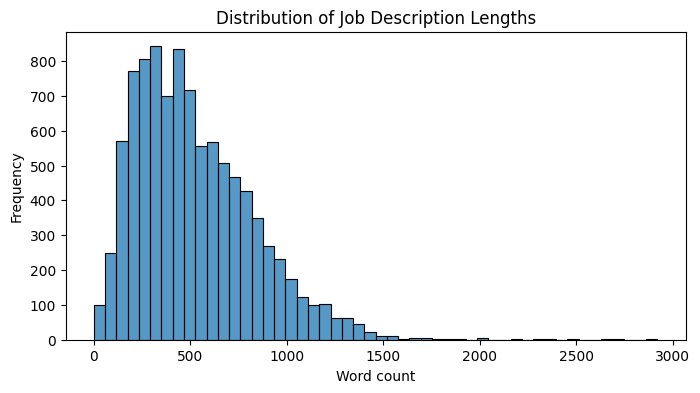

In [12]:
# --- Description length ---
df2["desc_len"] = df["description"].fillna("").apply(lambda x: len(x.split()))
#df["skills_len"] = df["skills_desc"].fillna("").apply(lambda x: len(x.split()))

plt.figure(figsize=(8,4))
sns.histplot(df2["desc_len"], bins=50, palette="mako")
plt.title("Distribution of Job Description Lengths")
plt.xlabel("Word count")
plt.ylabel("Frequency")
plt.show()

## Feature engineering
<a id="feature-engineering"></a>


### Merging Job desc and skill desc
<a id="description"></a>

- Both fields are free text and help to define the role by descibing the job requirement and required skillset.
- These two fields can be added as one field, and feed to nlp proceesing to identify the similarity

In [13]:
df2['description'] = df2['job_desc'] + ' ' + df2['skills_desc']


### Location
<a id="location"></a>

- Free-form location string (city, state, country). Parse this information to few features **city** and **state**
- Handling Noisy / Misspelled State Names (Using NLP/Fuzzy Matching), and impute state. Example, **Texas Metropolitan Area** as **TX**                                                                                                             


In [14]:
# Split into city, state
# Locations are often "City, State, Country"
df2[["city", "state"]] = df2["location"].str.split(",", n=2, expand=True)[[0, 1]]

# 3. Clean up whitespace
df2["city"] = df2["city"].str.strip()
df2["state"] = df2["state"].str.strip()

df2['city'] = df2['city'].fillna('')
df2['state'] = df2['state'].fillna('')

#df2[['state']].value_counts()
#df2[df2['state'].str.len() != 2][['state']].value_counts()


In [15]:
# install datasets lib if not installed
!pip install -q RapidFuzz


[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [16]:
from rapidfuzz import process

# Handling Noisy / Misspelled State Names (Using NLP/Fuzzy Matching)
us_state_abbrev = {
    'alabama': 'AL','alaska': 'AK','arizona': 'AZ','arkansas': 'AR','california': 'CA',
    'colorado': 'CO','connecticut': 'CT','delaware': 'DE','florida': 'FL','georgia': 'GA',
    'hawaii': 'HI','idaho': 'ID','illinois': 'IL','indiana': 'IN','iowa': 'IA',
    'kansas': 'KS','kentucky': 'KY','louisiana': 'LA','maine': 'ME','maryland': 'MD',
    'massachusetts': 'MA','michigan': 'MI','minnesota': 'MN','mississippi': 'MS','missouri': 'MO',
    'montana': 'MT','nebraska': 'NE','nevada': 'NV','new hampshire': 'NH','new jersey': 'NJ',
    'new mexico': 'NM','new york': 'NY','north carolina': 'NC','north dakota': 'ND','ohio': 'OH',
    'oklahoma': 'OK','oregon': 'OR','pennsylvania': 'PA','rhode island': 'RI','south carolina': 'SC',
    'south dakota': 'SD','tennessee': 'TN','texas': 'TX','utah': 'UT','vermont': 'VT',
    'virginia': 'VA','washington': 'WA','west virginia': 'WV','wisconsin': 'WI','wyoming': 'WY'
}

def get_state_abbrev(state_name):
    state_name = str(state_name).strip().lower()    
    if len(state_name) == 2:
        return state_name    
    match, score, _ = process.extractOne(state_name, us_state_abbrev.keys())
    if score > 80:  # confidence threshold
        return us_state_abbrev[match]
    return "us"

df2["state"] = df2["state"].apply(get_state_abbrev)


In [17]:
df2.reset_index(inplace=True, drop=True)


### NLP Debug functions and Tunning
<a id="nlp_debug"></a>

- This functions help to visualize the similarity comparision for better recommendation tuning
- Added a simple dataset that can be used for tunning


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def debug_similarity_two_texts(text1, text2, vectorizer):
    # Build TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    
    # Cosine similarity
    score = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0,0]
    
    # Feature names & weights
    feature_names = vectorizer.get_feature_names_out()
    weights_1 = tfidf_matrix.toarray()[0]
    weights_2 = tfidf_matrix.toarray()[1]
    
    # Debug print
    print(f"\nText1: {text1}")
    print(f"Text2: {text2}")
    print(f"Cosine Similarity: {score:.4f}\n")
    
    print("Token Weights (TF-IDF):")
    for word, w1, w2 in zip(feature_names, weights_1, weights_2):
        if w1 > 0 or w2 > 0:
            print(f"{word:15} | T1: {w1:.3f} | T2: {w2:.3f}")
    
    return score

def debug_similarity_df(df, text_cols, vectorizer):
    texts = df[text_cols].astype(str).agg(" ".join, axis=1).tolist()
    
    # TF-IDF vectorization
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Cosine similarity
    sim_matrix = cosine_similarity(tfidf_matrix)
    sim_df = pd.DataFrame(sim_matrix, index=df.index, columns=df.index)
    
    print("Cosine Similarity Matrix:")
    print(sim_df.round(3))
    
    # Debug token weights
    feature_names = vectorizer.get_feature_names_out()
    tfidf_array = tfidf_matrix.toarray()
    
    print("\n Token Weights (TF-IDF per row):")
    for i, row in df.iterrows():
        combined_text = " ".join([str(row[c]) for c in text_cols])
        print(f"\nRow {i} | Text (bag of cols): {combined_text}")
        weights = tfidf_array[list(df.index).index(i)]
        for word, weight in zip(feature_names, weights):
            if weight > 0:
                print(f"   {word:15} | {weight:.3f}")
    
    return sim_df

def debug_similarity_df_weighted(
    df: pd.DataFrame,
    col_vecs: dict,   # {"col_name": TfidfVectorizer, ...}
    weights: dict,    # {"col_name": float, ...}
    fit: bool = True,
    top_tokens: int = 10,
    topk_neighbors: int | None = None,
):
    """
    Per-column TF-IDFs with different vectorizers/weights, then cosine similarity.

    Returns:
        sim_df (DataFrame), X (sparse feature matrix), blocks (dict of per-col matrices)
    """
    # Transform each column separately
    blocks = {}
    for col, vec in col_vecs.items():
        series = df[col].fillna('').astype(str).tolist()
        Xi = vec.fit_transform(series) if fit else vec.transform(series)
        w = weights.get(col, 1.0)
        blocks[col] = Xi * w

    # Combined sparse matrix, L2 normalize for cosine
    X = hstack([blocks[c] for c in col_vecs.keys()])
    X = normalize(X)

    # Cosine similarity
    S = cosine_similarity(X)
    sim_df = pd.DataFrame(S, index=df.index, columns=df.index)
    print("Cosine Similarity Matrix:\n", sim_df.round(3))

    # Debug: show top tokens per column per row
    print("\nTop tokens per row (by column):")
    for i, idx in enumerate(df.index):
        print(f"\nRow {idx}:")
        for col, Xi in blocks.items():
            Xi = Xi.tocsr()
            start, end = Xi.indptr[i], Xi.indptr[i+1]
            cols = Xi.indices[start:end]
            data = Xi.data[start:end]
            if data.size == 0:
                continue
            order = np.argsort(data)[::-1][:top_tokens]
            fn = col_vecs[col].get_feature_names_out()
            print(f"  [{col}]")
            for j in order:
                print(f"    {fn[cols[j]]:28} {data[j]:.3f} (w={weights.get(col,1.0)})")

        if topk_neighbors:
            row = S[i].copy()
            row[i] = -1
            nn = np.argsort(row)[::-1][:topk_neighbors]
            print("  Nearest:", [(df.index[n], float(row[n])) for n in nn])

    return sim_df, X, blocks

In [19]:
#Simple dataset

#Clinical Pharmacist

df_test = pd.concat([
    df2[df2["title"].str.contains('herapist')],
    df2[df2["title"].str.contains('harmacist')],
    df2[df2["title"].str.contains('ccupati')],
    df2[df2["title"].str.contains('school')],
    df2[df2["title"].str.contains('eceptioni')],
    df2[df2["title"].str.contains('octor')],
])

df_test = df_test.drop_duplicates(subset=['job_id'], keep='first')

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Check State comparision
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b')

debug_similarity_two_texts('ca', 'ga', vectorizer)
debug_similarity_two_texts('ca', 'ca', vectorizer)
debug_similarity_two_texts('ca', 'tx', vectorizer)


Text1: ca
Text2: ga
Cosine Similarity: 0.0000

Token Weights (TF-IDF):
ca              | T1: 1.000 | T2: 0.000
ga              | T1: 0.000 | T2: 1.000

Text1: ca
Text2: ca
Cosine Similarity: 1.0000

Token Weights (TF-IDF):
ca              | T1: 1.000 | T2: 1.000

Text1: ca
Text2: tx
Cosine Similarity: 0.0000

Token Weights (TF-IDF):
ca              | T1: 1.000 | T2: 0.000
tx              | T1: 0.000 | T2: 1.000


np.float64(0.0)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Check Title Comparison
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
#df_test.sample(10)

debug_similarity_two_texts('Physical Therapist Assistant (PTA)', 'Physical Therapist / PT - Rehab', vectorizer)
debug_similarity_two_texts('Physical Therapist Assistant (PTA)', 'Physical Therapist', vectorizer)
debug_similarity_two_texts('Receptionist', 'Physical Therapist', vectorizer)
debug_similarity_two_texts('Occupational Therapy Assistant (COTA)', 'Physical Therapist', vectorizer)


Text1: Physical Therapist Assistant (PTA)
Text2: Physical Therapist / PT - Rehab
Cosine Similarity: 0.3361

Token Weights (TF-IDF):
assistant       | T1: 0.576 | T2: 0.000
physical        | T1: 0.410 | T2: 0.410
pt              | T1: 0.000 | T2: 0.576
pta             | T1: 0.576 | T2: 0.000
rehab           | T1: 0.000 | T2: 0.576
therapist       | T1: 0.410 | T2: 0.410

Text1: Physical Therapist Assistant (PTA)
Text2: Physical Therapist
Cosine Similarity: 0.5797

Token Weights (TF-IDF):
assistant       | T1: 0.576 | T2: 0.000
physical        | T1: 0.410 | T2: 0.707
pta             | T1: 0.576 | T2: 0.000
therapist       | T1: 0.410 | T2: 0.707

Text1: Receptionist
Text2: Physical Therapist
Cosine Similarity: 0.0000

Token Weights (TF-IDF):
physical        | T1: 0.000 | T2: 0.707
receptionist    | T1: 1.000 | T2: 0.000
therapist       | T1: 0.000 | T2: 0.707

Text1: Occupational Therapy Assistant (COTA)
Text2: Physical Therapist
Cosine Similarity: 0.0000

Token Weights (TF-IDF):
assist

np.float64(0.0)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

#description and state
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)


filter_list = [3885834175, 3884809163]
"""
debug_similarity_df(
    df_test.query('job_id in @filter_list'), 
    ['state','description'],
    vectorizer
)
"""

"\ndebug_similarity_df(\n    df_test.query('job_id in @filter_list'), \n    ['state','description'],\n    vectorizer\n)\n"

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.preprocessing import normalize


filter_list = [3885834175, 3885847114,3886465309,3885848050,3885848085,3884807483,3885843992]
#filter_list = [3885834175, 3886465309]
filter_list = [3885834204, 3885103659]

#display(df2.query('job_id in @filter_list'))
#display(df2.index[df2["job_id"] == 3885834175])
#display(df2.index)


col_vecs = {
    "job_desc": TfidfVectorizer(stop_words="english", ngram_range=(1,2), max_features=5000),
    "state": TfidfVectorizer(token_pattern=r'(?u)\b\w+\b'),
    "title": TfidfVectorizer(stop_words="english",  max_features=1000),

}
weights = {"job_desc": 0.8, "state": .1, "title": 1.2}
"""
sim_df, X, blocks = debug_similarity_df_weighted(
    df2.query('job_id in @filter_list'), 
    col_vecs=col_vecs,
    weights=weights,
    fit=True,
    top_tokens=8,
    topk_neighbors=3
)
"""
#0.08523881578183458

"\nsim_df, X, blocks = debug_similarity_df_weighted(\n    df2.query('job_id in @filter_list'), \n    col_vecs=col_vecs,\n    weights=weights,\n    fit=True,\n    top_tokens=8,\n    topk_neighbors=3\n)\n"

## Modeling
<a id="modeling"></a>

### Basic helper functions for recommendations
<a id="util-recommendation-helpers"></a>
- **get_recommendations_sort** gives the recommendations by extracting the similarity score from given vector matrix(pre-calculated) using sort
- **get_recommendations_argsort** gives the recommendations by extracting the similarity score from given vector matrix(pre-calculated) using argsort(better sorting performance)
- **get_recommendations_sort** gives the recommendations by calculating the cosine similarity using original dataset vector and just the job vector

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

display_columns = ['job_id', 'title', 'company_name', 'city', 'state']

def get_job_by_id(input_job_id, ori_df):
    idx = ori_df.index[ori_df["job_id"] == input_job_id].values[0].astype(int)
    input_df = ori_df[ori_df['job_id'] == input_job_id]

    display(input_df[display_columns])

    return input_df, idx
    

def get_recommendations_sort(input_job_id, ori_df, cos_sim_matrix, k = 10):

    input_df, idx = get_job_by_id(input_job_id, ori_df)

    sim_scores = list(enumerate(cos_sim_matrix[idx]))

    # Sort the jobs based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:k]
    job_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]

    similar_jobs = ori_df[display_columns].iloc[job_indices]
    similar_jobs['similarity_score'] = similarity_scores

    display(similar_jobs)

    return similar_jobs

def get_recommendations_argsort(input_job_id, ori_df, cos_sim_matrix, k = 10):

    input_df, idx = get_job_by_id(input_job_id, ori_df)

    sim_scores = cos_sim_matrix[idx]

    # takes lots of memory, not working for 50k records
    row = sim_scores.ravel()    
    topk = np.argsort(-row)[:k+1]  # +1 because it includes itself 
    job_indices = [i for i in topk if i != 0][:k]
    similarity_scores = row[topk]
    
    similar_jobs = ori_df[display_columns].iloc[job_indices]
    similar_jobs['similarity_score'] = similarity_scores[1:]

    display(similar_jobs)
    
    return similar_jobs


def get_recommendations_on_demand(input_job_id, ori_df, ori_df_vec, k = 10):

    input_df, idx = get_job_by_id(input_job_id, ori_df)
    
    input_df_vec = vectorize(input_df)

    cos_sim_matrix = cosine_similarity(ori_df_vec, input_df_vec)
    #print(f"cosine_sim shape is {cos_sim_matrix.shape}”)

    sim_scores = list(enumerate(cos_sim_matrix[idx]))

    # Sort the jobs based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    #sim_scores = sorted(enumerate(cosine_sim), key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:k]
    job_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]

    similar_jobs = ori_df[display_columns].iloc[job_indices]
    similar_jobs['similarity_score'] = similarity_scores
    
    display(similar_jobs)
    
    return similar_jobs

def get_cosine_similarity_matrix(tfidf_matrix, mode=None):    
    # Compute the cosine similarity matrix
    cosine_sim = None
    if mode == 'matrix-mul':
        cosine_sim = tfidf_matrix @ tfidf_matrix.T
        cosine_sim = cosine_sim.toarray()
    elif mode == 'linear_kernel':    
        cosine_sim = linear_kernel(tfidf_matrix)
    else:    
        cosine_sim = cosine_similarity(tfidf_matrix)
    print('computed the cosine similarity matrix')    
    return cosine_sim    

def print_vector_features(tfidf):
    print(tfidf_matrix.shape)
    feature_names = tfidf.get_feature_names_out()
    print(feature_names)


### Basic Recommendation with Job Description
<a id="basic-reco-model"></a>
- Recommendation based on TfidfVectorizer using max_feature and stop word
- Similarity conclusion with just one field Job description
- linear_kernel used to compute sparse_similarity_matrix

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


def vectorize(df):
    tfidf = TfidfVectorizer(
            stop_words='english', 
            #max_features=1000,
            #ngram_range=(1, 4)
        )
    tfidf_matrix = tfidf.fit_transform(df2['job_desc'])
    #tfidf_matrix = tfidf.fit_transform(df2['title'])

    #print_vector_features(tfidf_matrix)
    return tfidf_matrix

tfidf_matrix_basic = vectorize(df2)
cosine_sim_basic =  get_cosine_similarity_matrix(tfidf_matrix=tfidf_matrix_basic)
    

computed the cosine similarity matrix


In [26]:
job_id = 3885107176
recommendations = get_recommendations_sort(input_job_id=job_id, ori_df=df2, cos_sim_matrix=cosine_sim_basic, k=10)

,job_id,title,company_name,city,state
5852,3885107176,LICENSED PRACTICAL NURSE - BERMUDA COMMONS,Liberty Healthcare and Rehabilitation Services,Advance,nc


,job_id,title,company_name,city,state,similarity_score
5852,3885107176,LICENSED PRACTICAL NURSE - BERMUDA COMMONS,Liberty Healthcare and Rehabilitation Services,Advance,nc,1.000000
5419,3885101985,LICENSED PRACTICAL NURSE - MARY GRAN,Liberty Healthcare and Rehabilitation Services,Clinton,nc,0.947504
5809,3885106358,LICENSED PRACTICAL NURSE - ROYAL PARK REHABILI...,Liberty Healthcare and Rehabilitation Services,Matthews,nc,0.939394
5644,3885104442,LICENSED PRACTICAL NURSE - LPN - BARCLAY AT SO...,Liberty Healthcare and Rehabilitation Services,Charlotte,nc,0.938704
5725,3885105406,LICENSED PRACTICAL NURSE - LPN - BARCLAY AT SO...,Liberty Healthcare and Rehabilitation Services,Charlotte,nc,0.938704
5503,3885102698,LICENSED PRACTICAL NURSE - TEMPLETON OF CARY,Liberty Healthcare and Rehabilitation Services,Cary,nc,0.937291
5719,3885105395,LICENSED PRACTICAL NURSE (LPN) - THE FOLEY CEN...,Liberty Healthcare and Rehabilitation Services,Blowing Rock,nc,0.937291
5903,3885108042,LICENSED PRACTICAL NURSE (LPN) - SOUTHWOOD,Liberty Healthcare and Rehabilitation Services,Clinton,nc,0.936463
5863,3885107200,LICENSED PRACTICAL NURSE -WOODHAVEN,Liberty Healthcare and Rehabilitation Services,Lumberton,nc,0.936021
5658,3885104463,LICENSED PRACTICAL NURSE - SOUTHPORT HEALTH AN...,Liberty Healthcare and Rehabilitation Services,Southport,nc,0.935638


In [27]:
#Random testing

sample = df2.sample(n=1, random_state=None)[['job_id', 'title']]
job_id = sample['job_id'].values[0]

recommendations = get_recommendations_sort(input_job_id=job_id, ori_df=df2, cos_sim_matrix=cosine_sim_basic, k=10)

,job_id,title,company_name,city,state
2442,3884806509,HR and Operations Manager,Scion Staffing,San Francisco Bay Area,us


,job_id,title,company_name,city,state,similarity_score
2442,3884806509,HR and Operations Manager,Scion Staffing,San Francisco Bay Area,us,1.000000
3507,3884843642,Nonprofit HR and Operations Manager,Scion Staffing,San Francisco,ca,0.942353
3483,3884841822,Human Resources Assistant,Scion Staffing,San Francisco,ca,0.692966
8821,3886463344,Interim Deputy Director,Scion Staffing,Berkeley,ca,0.614370
8778,3886461868,Accounts Payable Data Entry Clerk,Scion Staffing,Boulder,co,0.534091
1618,3884438638,Azure Cloud Engineer,Scion Staffing,Oakland,ca,0.529626
3532,3884845344,AP Specialist,Scion Staffing,Portland,or,0.472556
4956,3884934666,Bilingual HR Manager,Masis Professional Group,Portage,wi,0.225247
2533,3884808478,Human Resources Business Partner,HR Exec Recruiting Firm,West Hollywood,ca,0.214339
1406,3884436833,HR Manager,Ingersoll Rand,West Chester,pa,0.208965


### Stemmer based Recommendation 
<a id="reco-model-stemming"></a>
- Recommendation based on TfidfVectorizer along with PorterStemmer
- cosine similarity matrix has build for all the jobs afront
- Following fields are used to find similarity using multi-column approach along with weights to influence the score: 
        - Job description, skill description, title, city and state
##### Stemming 
- content-based recommenders often rely on text similarity between job postings.
- Fast, lightweight, good enough if your data is noisy and you just need crude overlap (e.g., bag-of-words TF-IDF similarity).
- Words like “run” vs “running” vs “runs” should be treated as the same concept. Good for fast prototyping
- crude reductions (“studies” → “studi”) might hurt semantic meaning.
- It is not ideal for recommendation systems

In [28]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk

nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/selvarp1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# PorterStemmer tokenizer
stemmer = PorterStemmer()
def stem_tokenizer(text):
    tokens = word_tokenize(str(text).lower())
    stems = [stemmer.stem(tok) for tok in tokens if tok.isalpha()]
    return stems

stopwords_stemmed = [stemmer.stem(w) for w in ENGLISH_STOP_WORDS]


def vectorize(df):
    tfidf = TfidfVectorizer(
        tokenizer=stem_tokenizer, preprocessor=None,token_pattern=None,    
        stop_words=stopwords_stemmed, lowercase=True, max_features=100,
        ngram_range=(1, 2)
    )

    simple_tfidf = TfidfVectorizer(
        max_features=100, stop_words="english", lowercase=True
        #ngram_range=(1, 2),
    )

    state_tfidf = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b')
    
    tfidf_title = simple_tfidf.fit_transform(df2["title"])
    tfidf_job_desc = tfidf.fit_transform(df2["description"])
    tfidf_state = state_tfidf.fit_transform(df2["state"])

    w_job_desc = 0.8
    w_state = 0.2
    w_title = 1.1

    
    tfidf_matrix = hstack([
        tfidf_job_desc * w_job_desc, 
        tfidf_title * w_title,
        tfidf_state * w_state, 
    ])
    
    tfidf_matrix = normalize(tfidf_matrix)
    print(tfidf_matrix.shape)

    return tfidf_matrix
    
tfidf_matrix_stem = vectorize(df2)


#cosine_sim_stem =  get_cosine_similarity_matrix(tfidf_matrix=tfidf_matrix_stem, mode='matrix-mul')
cosine_sim_stem =  get_cosine_similarity_matrix(tfidf_matrix=tfidf_matrix_stem)

/Users/selvarp1/gitrepos/programming/jupyter-poc/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'becau', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  warnings.warn(


(9714, 253)
computed the cosine similarity matrix


In [30]:
job_id = 3885107176
recommendations = get_recommendations_argsort(input_job_id=job_id, ori_df=df2, cos_sim_matrix=cosine_sim_stem, k=10)
#recommendations = get_recommendations_on_demand(input_job_id=job_id, ori_df=df2, ori_df_vec=tfidf_matrix_stem, k=10)


,job_id,title,company_name,city,state
5852,3885107176,LICENSED PRACTICAL NURSE - BERMUDA COMMONS,Liberty Healthcare and Rehabilitation Services,Advance,nc


,job_id,title,company_name,city,state,similarity_score
5852,3885107176,LICENSED PRACTICAL NURSE - BERMUDA COMMONS,Liberty Healthcare and Rehabilitation Services,Advance,nc,1.000000
5419,3885101985,LICENSED PRACTICAL NURSE - MARY GRAN,Liberty Healthcare and Rehabilitation Services,Clinton,nc,0.999797
5799,3885106346,LICENSED PRACTICAL NURSE - BERMUDA COMMONS,Liberty Healthcare and Rehabilitation Services,Advance,nc,0.999797
5712,3885105384,LICENSED PRACTICAL NURSE - SOUTHWOOD,Liberty Healthcare and Rehabilitation Services,Clinton,nc,0.999797
5854,3885107180,LICENSED PRACTICAL NURSE - LIBERTY COMMONS OF ...,Liberty Healthcare and Rehabilitation Services,Whiteville,nc,0.999797
5855,3885107181,LICENSED PRACTICAL NURSE - LIBERTY COMMONS OF ...,Liberty Healthcare and Rehabilitation Services,Whiteville,nc,0.999797
5863,3885107200,LICENSED PRACTICAL NURSE -WOODHAVEN,Liberty Healthcare and Rehabilitation Services,Lumberton,nc,0.999797
5740,3885105428,LICENSED PRACTICAL NURSE - BERMUDA COMMONS,Liberty Healthcare and Rehabilitation Services,Advance,nc,0.999797
5572,3885103678,LICENSED PRACTICAL NURSE -WOODHAVEN,Liberty Healthcare and Rehabilitation Services,Lumberton,nc,0.999797
5737,3885105422,LICENSED PRACTICAL NURSE - LIBERTY COMMONS OF ...,Liberty Healthcare and Rehabilitation Services,Whiteville,nc,0.999797


In [31]:
# Random testing

sample = df2.sample(n=1, random_state=None)[['job_id', 'title']]
job_id = sample['job_id'].values[0]

recommendations = get_recommendations_argsort(input_job_id=job_id, ori_df=df2, cos_sim_matrix=cosine_sim_stem, k=10)

,job_id,title,company_name,city,state
422,3840554223,Instructional Coach - Elementary,Truth Academy Dallas,Dallas,tx


,job_id,title,company_name,city,state,similarity_score
422,3840554223,Instructional Coach - Elementary,Truth Academy Dallas,Dallas,tx,0.731580
5893,3885107976,Elementary 5th Grade Teacher,Destiny Christian School,Rochester,ny,0.677941
9038,3886479617,Teacher,GREGORY-PORTLAND ISD,Portland,tx,0.588167
5538,3885103417,CUA 2 Educational Liaison,Asociacion Puertorriquenos en Marcha,Philadelphia,pa,0.521553
497,3857787956,Researcher,University of Tehran,San Diego,ca,0.516365
8107,3885874004,Smartboard Video Creator for Grades 1-5,Endeavor Academy,United States,us,0.513760
2526,3884808396,Experiential Education Coach,Embarc,Chicago,il,0.504977
2661,3884813104,Training Instructor (Vocational Training Instr...,Federal Bureau of Prisons - Career Connections,Jonesville,va,0.497447
233,3729754558,tester,GSOBA,Los Angeles,ca,0.496029
1838,3884440484,Museum Educator,African American Museum of Iowa,Cedar Rapids,ia,0.491009


### Lemmatizer based Recommendation 
<a id="basic-reco-lemmatize"></a>
- Recommendation based on TfidfVectorizer using spaCy
- Following fields are used to find similarity using multi-column approach along with weights to influence the score: Job description, skill description, title and state
        

In [32]:
# install datasets lib if not installed
!pip install -q spacy


[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [33]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 68.0 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [34]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from scipy.sparse import hstack
from sklearn.preprocessing import normalize


# Get the default list of English stopwords
stop_words = stopwords.words('english')

# Create a list of new custom words
new_stopwords = ["manager","supervisor","administrator","assistant","associate"]

# Use .extend() to add the list to the existing list
#stop_words.extend(new_stopwords)

# For faster lookups during processing, convert the list to a set
stop_words_set = set(stop_words)

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])  # keep tagger+lemmatizer


In [35]:
def spacy_lemmatizer(text):
    doc = nlp(text.lower())
    return [t.lemma_ for t in doc if t.is_alpha and not t.is_stop and len(t) > 1]


def vectorize(df):
    tfidf = TfidfVectorizer(
        tokenizer=spacy_lemmatizer, preprocessor=None,token_pattern=None,    
        stop_words='english', max_features=100,
        ngram_range=(1, 2)
    )

    simple_tfidf = TfidfVectorizer(
        max_features=100, stop_words='english'
        #ngram_range=(1, 2),
    )

    state_tfidf = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b')
    
    tfidf_title = tfidf.fit_transform(df2["title"])
    tfidf_job_desc = simple_tfidf.fit_transform(df2["description"])
    tfidf_state = state_tfidf.fit_transform(df2["state"])

    w_job_desc = 0.8
    w_state = 0.2
    w_title = 1.1

    
    tfidf_matrix = hstack([
        tfidf_job_desc * w_job_desc, 
        tfidf_title * w_title,
        tfidf_state * w_state, 
    ])
    
    tfidf_matrix = normalize(tfidf_matrix)
    print(tfidf_matrix.shape)

    return tfidf_matrix
    
tfidf_matrix_lemma = vectorize(df2)
cosine_sim_lemma =  get_cosine_similarity_matrix(tfidf_matrix=tfidf_matrix_lemma) 

(9714, 253)
computed the cosine similarity matrix


In [36]:
job_id = 3885107176
recommendations = get_recommendations_argsort(input_job_id=job_id, ori_df=df2, cos_sim_matrix=cosine_sim_lemma, k=10)
#recommendations = get_recommendations_on_demand(input_job_id=job_id, ori_df=df2, ori_df_vec=tfidf_matrix_lemma, k=10)


,job_id,title,company_name,city,state
5852,3885107176,LICENSED PRACTICAL NURSE - BERMUDA COMMONS,Liberty Healthcare and Rehabilitation Services,Advance,nc


,job_id,title,company_name,city,state,similarity_score
5852,3885107176,LICENSED PRACTICAL NURSE - BERMUDA COMMONS,Liberty Healthcare and Rehabilitation Services,Advance,nc,1.00000
5419,3885101985,LICENSED PRACTICAL NURSE - MARY GRAN,Liberty Healthcare and Rehabilitation Services,Clinton,nc,0.99813
5855,3885107181,LICENSED PRACTICAL NURSE - LIBERTY COMMONS OF ...,Liberty Healthcare and Rehabilitation Services,Whiteville,nc,0.99813
5491,3885102668,LICENSED PRACTICAL NURSE - BERMUDA COMMONS,Liberty Healthcare and Rehabilitation Services,Advance,nc,0.99813
5503,3885102698,LICENSED PRACTICAL NURSE - TEMPLETON OF CARY,Liberty Healthcare and Rehabilitation Services,Cary,nc,0.99813
5572,3885103678,LICENSED PRACTICAL NURSE -WOODHAVEN,Liberty Healthcare and Rehabilitation Services,Lumberton,nc,0.99813
5653,3885104458,LICENSED PRACTICAL NURSE -WOODHAVEN,Liberty Healthcare and Rehabilitation Services,Lumberton,nc,0.99813
5657,3885104462,LICENSED PRACTICAL NURSE - LIBERTY COMMONS OF ...,Liberty Healthcare and Rehabilitation Services,Whiteville,nc,0.99813
5712,3885105384,LICENSED PRACTICAL NURSE - SOUTHWOOD,Liberty Healthcare and Rehabilitation Services,Clinton,nc,0.99813
5727,3885105408,LICENSED PRACTICAL NURSE - MARY GRAN,Liberty Healthcare and Rehabilitation Services,Clinton,nc,0.99813


In [37]:
#Random testing

sample = df2.sample(n=1, random_state=None)[['job_id', 'title']]
job_id = sample['job_id'].values[0]

recommendations = get_recommendations_argsort(input_job_id=job_id, ori_df=df2, cos_sim_matrix=cosine_sim_lemma, k=10)

,job_id,title,company_name,city,state
1524,3884437817,New Home Sales Associate - Hillsborough County,Richmond American Homes,Apollo Beach,fl


,job_id,title,company_name,city,state,similarity_score
1524,3884437817,New Home Sales Associate - Hillsborough County,Richmond American Homes,Apollo Beach,fl,0.978836
2165,3884444186,New Home Sales Associate - Nashville,Richmond American Homes,Nashville,tn,0.763334
368,3821689873,Sales Associate,The Epicure,United States,us,0.734527
8654,3886455816,Inside Sales Associate,POOLCORP,Jupiter,fl,0.726930
3455,3884839167,"Sales Associate, Seasonal/Flex Only, Flat Iron...","Williams-Sonoma, Inc.",Broomfield,co,0.714691
1899,3884440876,Counter Sales Associate,White Cap,St Cloud,mn,0.700361
8344,3886444755,Sales Associate - Chico's,"Chico's FAS, Inc.",Charlotte,nc,0.700361
8355,3886445715,Sales Associate - Chico's,"Chico's FAS, Inc.",Harrisburg,pa,0.700361
9391,3886835914,Sales Associate - White House Black Market,"Chico's FAS, Inc.",Myrtle Beach,sc,0.699684
3572,3884848788,Seasonal Sales Associate,Jos. A. Bank Clothiers,West Hartford,ct,0.697910


## Conclusion
<a id="conclusion"></a>

This project demonstrates how intelligent recommendation techniques can streamline the job discovery process for candidates. By analyzing shared skills, job descriptions, and responsibilities alongside contextual factors such as location, the system reduces the burden on job seekers to know every possible title variation. It proactively surfaces relevant opportunities once a user views or selects a posting.

This basic recommendation system can be enhanced and scaled in several ways:

- **Add Filters:**  
  Introduce additional filtering options such as city, experience level, or job type to narrow down results.  

- **User Profile:**  
  Building user profile help to recommand based on collaborate recommendation filtering, it will be more relevant recommandation

- **Leverage Advanced NLP:**  
  Improve text understanding by applying modern NLP methods like word embeddings (*Word2Vec, GloVe, BERT*) to capture semantic similarities in job titles and descriptions.  

- **Scale for Real-Time Use:**  
  Extend the system to handle larger datasets efficiently, enabling real-time job recommendations for users.  